### Oscillator-Qubit Architecture
The displacment operator will be (generally) part of the native gate set on this architecture, so we can just implement it directly.

In [6]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector

In [7]:
def simulate_mode_displacement(alpha, noise=True, photon_loss_rate=0.0001, gate_time = 100, shots=100):
    """
    Simulates a qumode initialized in Fock state |3> with a displacement gate.
    
    Args:
        alpha (float): Size of the displacement (amplitude).
        noise (bool): Whether to include photon loss noise in the simulation.
        photon_loss_rate (float): Photon loss rate in units of 1/ns (only relevant if noise=True).
        shots (int): Number of shots for the simulation (only relevant if noise=True).
        
    Returns:
        Statevector: If noise=True, returns a tuple of statevectors. If noise=False, returns the statevector.
    """
    # Define the number of qumodes and qubits per qumode
    num_qumodes = 1
    num_qubits_per_qumode = 4  # Cutoff = 2^4 = 16
    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    
    # Create the circuit
    cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode) if noise else None
    circuit = c2qa.CVCircuit(qmr, cr) if noise else c2qa.CVCircuit(qmr)
    
    # Initialize the qumode in Fock state |0>
    circuit.cv_initialize(1, qmr[0])
    
    # Apply a displacement gate with specified alpha
    circuit.cv_d(alpha, qmr[0], duration=gate_time if noise else None, unit="ns" if noise else None)
    
    if noise:
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        
        # Run the simulation with noise
        state, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass
        )
        return state
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state

In [8]:
def compute_average_fidelity(alpha, photon_loss_rate=0.0001, gate_time=100, shots=100):
    """
    Computes the average fidelity between the noiseless statevector and individual noisy statevectors,
    and includes the error from shot noise using numpy functions.
    
    Args:
        alpha (float): Size of the displacement (amplitude).
        photon_loss_rate (float): Photon loss rate in units of 1/ns.
        gate_time (float): Gate time in ns.
        shots (int): Number of shots for the noisy simulation.
        
    Returns:
        tuple: The average fidelity and the standard error (shot noise error).
    """
    # Simulate the noiseless state
    state_no_noise = simulate_mode_displacement(alpha, noise=False)
    
    # Simulate the noisy statevectors
    noisy_statevectors = simulate_mode_displacement(alpha, noise=True, photon_loss_rate=photon_loss_rate, gate_time=gate_time, shots=shots)
    
    # Calculate fidelity for each noisy statevector
    fidelities = [state_fidelity(state_no_noise, noisy_state) for noisy_state in noisy_statevectors]
    
    # Compute the average fidelity using numpy
    average_fidelity = np.average(fidelities)
    
    # Calculate the standard error
    std_error = np.std(fidelities) / np.sqrt(shots)
    
    return average_fidelity, std_error


In [9]:
## Suppress specific warnings
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", message="PhotonLossNoisePass ignores instructions without duration")
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

# Define parameters
photon_loss_rates = np.linspace(1e-4, 2e-2, num=20)  # Linearly spaced points from 10^-4 to 10^-2
gate_times = [5, 20, 50]  # Gate times in ns
alpha = 0.5  # Fixed displacement value
shots = 1024

# Placeholder for results
results = {}

for gate_time in gate_times:
    # Initialize placeholders for fidelities and errors
    fidelities = []
    errors = []
    for photon_loss_rate in photon_loss_rates:
        average_fidelity, std_error = compute_average_fidelity(alpha, photon_loss_rate, gate_time, shots)
        fidelities.append(average_fidelity)
        errors.append(std_error)
    
    # Store both fidelities and errors for the current gate time
    results[gate_time] = {
        'fidelities': fidelities,
        'errors': errors
    }


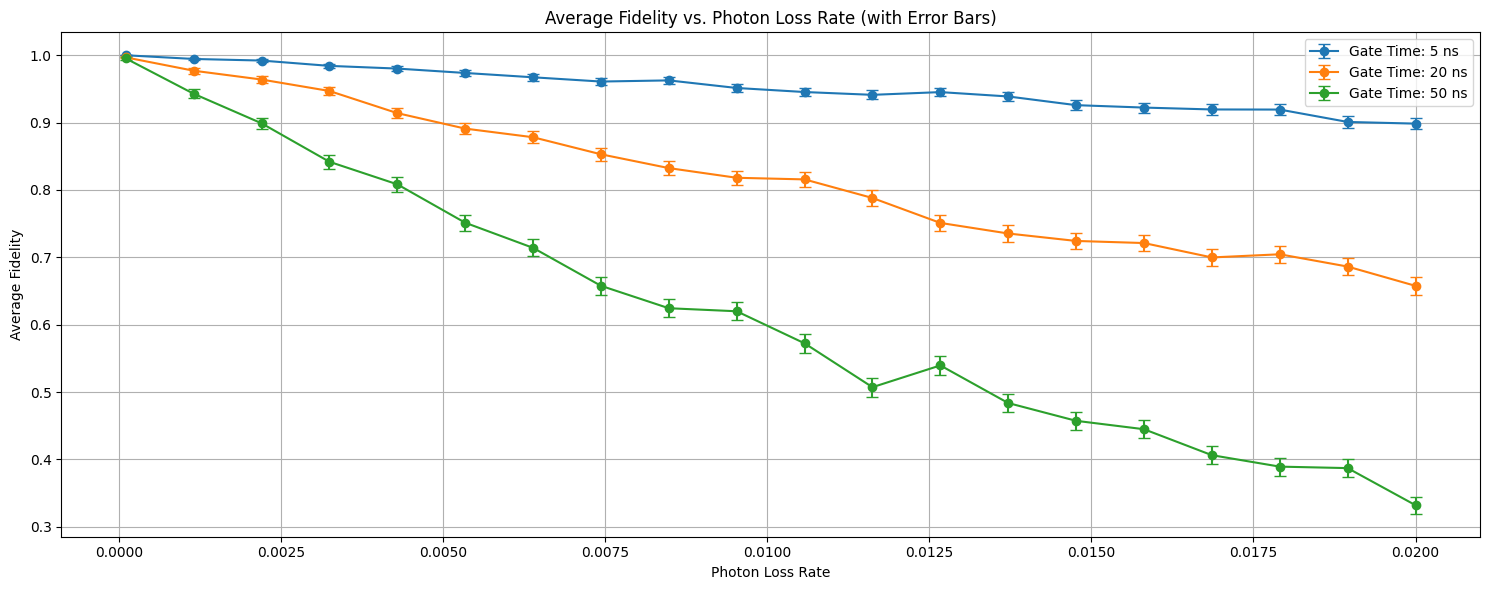

In [ ]:
plt.figure(figsize=(15, 6))

# Plot fidelity vs. photon loss rate with error bars
for gate_time in gate_times:
    fidelities = results[gate_time]['fidelities']
    errors = results[gate_time]['errors']
    plt.errorbar(
        photon_loss_rates,
        fidelities,
        yerr=errors,
        fmt='o-',  # 'o-' for a line with circular markers
        capsize=4,  # Add caps to the error bars
        label=f'Gate Time: {gate_time} ns'
    )

# Configure the plot
plt.xlabel('Photon Loss Rate')
plt.ylabel('Average Fidelity')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()
